<a href="https://colab.research.google.com/github/santoreb/Image_Classification_ChestXray_Direction_Prediction/blob/main/Train_Small_Model_1_Directions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from zipfile import ZipFile
file_name = "/content/Directions01_RGB.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [50]:
import torch
from torchvision import datasets, models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

transform = ToTensor()

train_data = datasets.ImageFolder(root = "/content/Directions01_RGB/train", transform=transform)
test_data = datasets.ImageFolder(root = "/content/Directions01_RGB/test", transform=transform)

print(train_data)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 948
    Root location: /content/Directions01_RGB/train
    StandardTransform
Transform: ToTensor()
Dataset ImageFolder
    Number of datapoints: 40
    Root location: /content/Directions01_RGB/test
    StandardTransform
Transform: ToTensor()


torch.Size([3, 128, 128])
tensor(3)


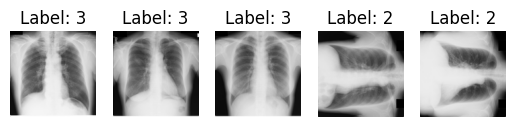

In [27]:
loaders = {
    'train': torch.utils.data.DataLoader(train_data,
                                         batch_size=10,
                                         shuffle = True,
                                         num_workers=1),
    'test':  torch.utils.data.DataLoader(test_data,
                                         batch_size=40,
                                         shuffle = True,
                                         num_workers=1),
}
loaders

# Get a batch of images and labels
images, labels = next(iter(loaders['train']))

print(images[0].shape)
print(labels[0])

# Visualize the images
fig, axs = plt.subplots(1, 5)
for i in range(5):
    axs[i].imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) format
    axs[i].set_title(f"Label: {labels[i]}")
    axs[i].axis('off')

plt.show()

In [6]:
model = models.resnet18(pretrained=True)
model

num_features = model.fc.in_features
print('Number of features from pre-trained model', num_features)

model.fc = nn.Linear(num_features, 4)
model = model.to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


Number of features from pre-trained model 512


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.01)

num_epochs = 10

def train(num_epochs, model, loaders):
  model.train()
  total_step = len(loaders['train'])

  for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(loaders['train']):
      b_x = Variable(images)
      b_y = Variable(labels)
      b_x = b_x.to(device)
      b_y = b_y.to(device)
      output = model(b_x)
      loss = loss_func(output, b_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if (i+1) % 10 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i+1, total_step, loss.item()))
        pass
    pass
  pass
train(num_epochs, model, loaders)

Epoch [1/10], Step [10/95], Loss: 0.3081
Epoch [1/10], Step [20/95], Loss: 0.0078
Epoch [1/10], Step [30/95], Loss: 1.5699
Epoch [1/10], Step [40/95], Loss: 0.1582
Epoch [1/10], Step [50/95], Loss: 0.0379
Epoch [1/10], Step [60/95], Loss: 0.0701
Epoch [1/10], Step [70/95], Loss: 0.2292
Epoch [1/10], Step [80/95], Loss: 0.0454
Epoch [1/10], Step [90/95], Loss: 0.0007
Epoch [2/10], Step [10/95], Loss: 0.0232
Epoch [2/10], Step [20/95], Loss: 0.0000
Epoch [2/10], Step [30/95], Loss: 0.0764
Epoch [2/10], Step [40/95], Loss: 0.2114
Epoch [2/10], Step [50/95], Loss: 0.3096
Epoch [2/10], Step [60/95], Loss: 1.3977
Epoch [2/10], Step [70/95], Loss: 0.5641
Epoch [2/10], Step [80/95], Loss: 0.0000
Epoch [2/10], Step [90/95], Loss: 0.0010
Epoch [3/10], Step [10/95], Loss: 0.0006
Epoch [3/10], Step [20/95], Loss: 0.0001
Epoch [3/10], Step [30/95], Loss: 0.0007
Epoch [3/10], Step [40/95], Loss: 0.0000
Epoch [3/10], Step [50/95], Loss: 0.0005
Epoch [3/10], Step [60/95], Loss: 0.0054
Epoch [3/10], St

Test Accuracy of the model on the 10 test images: 1.00


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


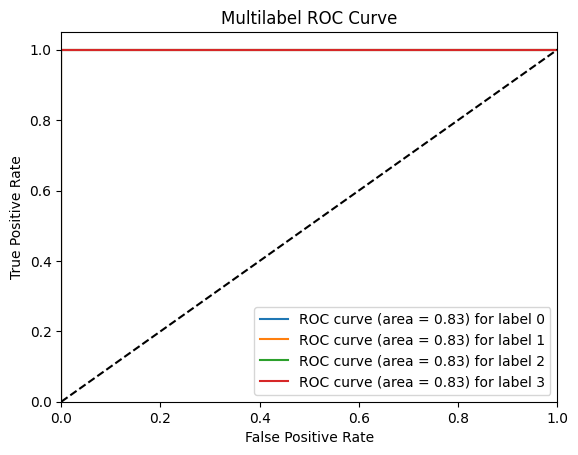

Total AUC:  1.0


In [60]:
def test():
  model.eval()
  softmax = nn.Softmax()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loaders['test']:
      images = images.to(device)
      labels = labels.to(device)
      labels_binarized = label_binarize(labels.to('cpu'), classes=[0, 1, 2, 3])
      test_output = model(images)
      pred_y = torch.max(test_output, 1)[1].data.squeeze()
      accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
      print('Test Accuracy of the model on the 10 test images: %.2f'%accuracy)
      roc_auc = roc_auc_score(labels.to('cpu'), softmax(test_output.to('cpu')), multi_class='ovo')

      # # Compute ROC curve and ROC area for each class
      fpr = dict()
      tpr = dict()
      roc_auc_individual = dict()
      for i in range(labels_binarized.shape[1]):
          fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], test_output[:, i].to('cpu'))
          roc_auc_individual[i] = roc_auc_score(fpr[i], tpr[i])

      # Plot all ROC curves
      plt.figure()
      for i in range(labels_binarized.shape[1]):
          plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc_individual[i]:.2f}) for label {i}')
      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Multilabel ROC Curve')
      plt.legend(loc="lower right")
      plt.show()
      print("Total AUC: ", roc_auc)
test()